# 1. Importação e setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
notebook_path = Path.cwd()
project_root = str(notebook_path.parent.parent) + "\\src"
sys.path.append(project_root)

In [3]:
project_root

'd:\\projetos\\roadSafeAi\\RoadSafeAI\\src'

In [4]:
df = pd.read_csv("D:\\projetos\\roadSafeAi\\RoadSafeAI\\files\\processed\\maranhao\\datatran_ma_merged_base_2007_2024.csv",sep=";")

# Justificativa para o Pré-processamento dos Dados:

## Análise Inicial dos Dados

In [5]:
print(f"Dimensões do dataset: {df.shape}")

Dimensões do dataset: (34153, 25)


### 1 - Precessos realizados em data_cleaning.py

#### 1.1 Análise de valores nulos e variações

In [6]:
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100

print("Análise de valores ausentes:")
for col, missing in missing_percentages[missing_percentages > 0].items():
    print(f"{col}: {missing:.2f}%")

Análise de valores ausentes:
tipo_acidente: 0.01%


In [7]:
null_variations = ['null', '(null)', 'NULL', '(NULL)', 'NaN', 'nan', 'NAN', 
                  'undefined', '', ' ', None]

for value in null_variations:
    count = df.isin([value]).sum().sum()
    print(f"Ocorrências de '{value}': {count}")

Ocorrências de 'null': 0
Ocorrências de '(null)': 2
Ocorrências de 'NULL': 0
Ocorrências de '(NULL)': 0
Ocorrências de 'NaN': 0
Ocorrências de 'nan': 0
Ocorrências de 'NAN': 0
Ocorrências de 'undefined': 0
Ocorrências de '': 0
Ocorrências de ' ': 0
Ocorrências de 'None': 0


#### 1.2 Remoção de Colunas (DataCleaning)
As seguintes colunas são removidas:

* 'id': Identificador sem valor analítico

* 'uf': Redundante pois todos os dados são do MA

* 'tracado_via': O problema desse campo é que de 2007 a 2016, informações do tracado da via esta incompleto. e como a coluna também esta desbalanceada, onde o campo Reta é cerca de 82% dos dados, por isso acreditamos que a melhor escolha é remover esse campo.

* 'feridos': Informação já contida em feridos_leves e feridos_graves

* 'fase_dia': Substituída por período_dia mais granular

In [8]:
df['tracado_via'].value_counts(normalize=True)*100

tracado_via
Reta                                  81.981085
Curva                                  9.969842
Cruzamento                             1.756800
Declive                                1.138992
Aclive                                 0.931104
                                        ...    
Reta;Interseção de Vias;Em Obras       0.002928
Retorno Regulamentado;Aclive           0.002928
Em Obras;Declive;Curva                 0.002928
Reta;Retorno Regulamentado;Declive     0.002928
Reta;Declive;Viaduto                   0.002928
Name: proportion, Length: 109, dtype: float64

In [9]:
df[['feridos','feridos_leves','feridos_graves']].head(11)

,feridos,feridos_leves,feridos_graves
0,0,0,0
1,1,1,0
2,3,3,0
3,0,0,0
4,0,0,0
5,1,0,1
6,0,0,0
7,0,0,0
8,0,0,0
9,1,1,0


In [10]:
df['fase_dia'].unique()

array(['Pleno dia', 'Plena noite', 'Anoitecer', 'Amanhecer', '(null)',
       'Plena Noite'], dtype=object)

### 2. Padronização de dados em data_standardize.py

#### 2.1 Padronização dias da semana

Os dias da semana estão declarados com diferentes valores para o mesmo dia

In [11]:
df['dia_semana'].unique()

array(['Segunda', 'Quinta', 'Domingo', 'Terça', 'Sexta', 'Quarta',
       'Sábado', 'domingo', 'segunda-feira', 'terça-feira',
       'quarta-feira', 'quinta-feira', 'sexta-feira', 'sábado'],
      dtype=object)

#### 2.2. Padronizar uso solo

Segundo dicionario de dados da PRF, Rural é igual a Não a partir de 2017, e Urbano igual a Sim. Para padronizar essa coluna, vai ser adotado o padrão de Rural igual a Não, e Urbano igual a Sim para todos os dados.

In [12]:
df['uso_solo'].unique()

array(['Rural', 'Urbano', 'Não', 'Sim'], dtype=object)

#### 2.3 padronizar valores das colunas tipo_acidente e classificacao_acidente

In [13]:
df['tipo_acidente'].unique()

array(['Capotamento', 'Saída de Pista', 'Atropelamento de animal',
       'Colisão lateral', 'Atropelamento de pessoa',
       'Colisão Transversal', 'Tombamento', 'Colisão traseira',
       'Colisão frontal', 'Colisão com objeto fixo',
       'Colisão com bicicleta', 'Derramamento de Carga',
       'Queda de motocicleta / bicicleta / veículo', 'Danos Eventuais',
       'Colisão com objeto móvel', 'Incêndio',
       'Saída de leito carroçável', 'Colisão com objeto estático',
       'Colisão transversal', 'Atropelamento de Animal',
       'Atropelamento de Pedestre', 'Engavetamento',
       'Queda de ocupante de veículo', 'Colisão com objeto em movimento',
       'Derramamento de carga', 'Danos eventuais', 'Colisão com objeto',
       nan, 'Colisão lateral sentido oposto',
       'Colisão lateral mesmo sentido', 'Eventos atípicos'], dtype=object)

In [14]:
df['classificacao_acidente'].unique()

array(['Sem Vítimas', 'Com Vítimas Fatais', 'Com Vítimas Feridas',
       'Ignorado', '(null)'], dtype=object)

### 3. Feature Engineering em feature_engineering.py

#### 3.1 Criar periodo do dia

 Períodos:
  - Madrugada: 00:00 - 05:59
  - Manhã: 06:00 - 11:59
  - Tarde: 12:00 - 17:59
  - Noite: 18:00 - 23:59

In [15]:
df.head()

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos
0,402769.0,2007-01-01,Segunda,09:50:00,MA,316,516.1,CAXIAS,Ultrapassagem indevida,Capotamento,...,Curva,Rural,2,0,0,0,2,0,0,2
1,210762.0,2007-01-01,Segunda,03:30:00,MA,222,556.3,BOM JESUS DAS SELVAS,Velocidade incompatível,Saída de Pista,...,Curva,Rural,2,1,1,0,0,0,1,1
2,173998.0,2007-01-01,Segunda,18:00:00,MA,230,23.9,BARAO DE GRAJAU,Animais na Pista,Atropelamento de animal,...,Reta,Rural,4,0,3,0,1,0,3,1
3,173939.0,2007-01-01,Segunda,15:00:00,MA,10,216.8,GOVERNADOR EDISON LOBAO,Defeito na via,Saída de Pista,...,Reta,Rural,1,0,0,0,1,0,0,1
4,175809.0,2007-01-01,Segunda,08:20:00,MA,135,23.0,SAO LUIS,Falta de atenção,Colisão lateral,...,Reta,Rural,2,0,0,0,2,0,0,2


In [16]:
def categorizar_periodo(hora_str):
    hora = int(hora_str.split(':')[0])
        
    if 0 <= hora < 6:
        return 'madrugada'
    elif 6 <= hora < 12:
        return 'manha'
    elif 12 <= hora < 18:
        return 'tarde'
    else:
        return 'noite'

df['periodo_dia'] = df['horario'].apply(categorizar_periodo)
periodo_dist = df['periodo_dia'].value_counts()
print("\nDistribuição por período do dia:")
print(periodo_dist)


Distribuição por período do dia:
periodo_dia
tarde        11472
manha         9591
noite         9399
madrugada     3691
Name: count, dtype: int64


#### 3.2 Criar gravidade acidente

Categorias:
  - Sem_vitimas: apenas ilesos
  - Leve: apenas feridos leves
  - Grave: presença de feridos graves
  - Fatal: presença de mortos

In [17]:
def classificar_gravidade(row):
  if row['mortos'] > 0:
      return 'fatal'
  elif row['feridos_graves'] > 0:
      return 'grave'
  elif row['feridos_leves'] > 0:
      return 'leve'
  else:
      return 'sem_vitimas'
    
df['gravidade_acidente'] = df.apply(classificar_gravidade, axis=1)
distribuicao = df['gravidade_acidente'].value_counts()
print("\nDistribuição por gravidade do acidente:")
print(distribuicao)


Distribuição por gravidade do acidente:
gravidade_acidente
sem_vitimas    14652
leve            8846
grave           6767
fatal           3888
Name: count, dtype: int64


#### 3.3 Tratar causas de acidentes

Diminuir causas em grupos:
- Falhas Humanas - Atenção
- Falhas Humanas - Comportamento de Risco
- Fatores Externos - Animais
- Problemas Técnicos - Veículo
- Problemas Técnicos - Via
- Condições do Condutor - Álcool e Drogas
- Condições do Condutor - Fadiga
- Fatores Ambientais

#### 4 Codificação de colunas numericas em data_encoding.py

Estratégias:
- OneHot: Para colunas com poucas categorias
- Label: Para colunas com ordem implícita
- Target: Para colunas com muitas categorias

### 5 Balanceamento da classe em data_balancing.py

In [18]:
target_dist = df['gravidade_acidente'].value_counts()
print("\nDistribuição da variável target:")
print(target_dist)
print("\nPercentuais:")
print((target_dist / len(df) * 100).round(2))


Distribuição da variável target:
gravidade_acidente
sem_vitimas    14652
leve            8846
grave           6767
fatal           3888
Name: count, dtype: int64

Percentuais:
gravidade_acidente
sem_vitimas    42.90
leve           25.90
grave          19.81
fatal          11.38
Name: count, dtype: float64


Existem muito mais aciedentes sem vitimas, como o objetivo é identificar os acidentes graves e fatais, sera realiza o balanceamento de classes.

# Analise Exploratoria dos dados

## Outliers

In [19]:
print("Dimensões do dataset:", df.shape)
print("\nPrimeiras linhas do dataset:")
df.head()

Dimensões do dataset: (34153, 27)

Primeiras linhas do dataset:


,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,...,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,periodo_dia,gravidade_acidente
0,402769.0,2007-01-01,Segunda,09:50:00,MA,316,516.1,CAXIAS,Ultrapassagem indevida,Capotamento,...,2,0,0,0,2,0,0,2,manha,sem_vitimas
1,210762.0,2007-01-01,Segunda,03:30:00,MA,222,556.3,BOM JESUS DAS SELVAS,Velocidade incompatível,Saída de Pista,...,2,1,1,0,0,0,1,1,madrugada,fatal
2,173998.0,2007-01-01,Segunda,18:00:00,MA,230,23.9,BARAO DE GRAJAU,Animais na Pista,Atropelamento de animal,...,4,0,3,0,1,0,3,1,noite,leve
3,173939.0,2007-01-01,Segunda,15:00:00,MA,10,216.8,GOVERNADOR EDISON LOBAO,Defeito na via,Saída de Pista,...,1,0,0,0,1,0,0,1,tarde,sem_vitimas
4,175809.0,2007-01-01,Segunda,08:20:00,MA,135,23.0,SAO LUIS,Falta de atenção,Colisão lateral,...,2,0,0,0,2,0,0,2,manha,sem_vitimas


In [20]:
def analyze_outliers(df, column):
    """
    Função para análise detalhada de outliers em uma coluna
    """
    # Calculando estatísticas
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificando outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    
    # Estatísticas descritivas
    stats_dict = {
        'Média': df[column].mean(),
        'Mediana': df[column].median(),
        'Desvio Padrão': df[column].std(),
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Limite Inferior': lower_bound,
        'Limite Superior': upper_bound,
        'Mínimo': df[column].min(),
        'Máximo': df[column].max(),
        'Quantidade de Outliers': len(outliers),
        'Percentual de Outliers': (len(outliers) / len(df)) * 100
    }
    
    return pd.Series(stats_dict)

In [21]:
colunas_numericas = ['pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 
                     'ilesos', 'ignorados', 'feridos', 'veiculos']

# Criar DataFrame com estatísticas de outliers para todas as colunas
outliers_stats = pd.DataFrame([analyze_outliers(df, col) for col in colunas_numericas],
                            index=colunas_numericas)
print("Estatísticas de Outliers:")
outliers_stats

Estatísticas de Outliers:


,Média,Mediana,Desvio Padrão,Q1,Q3,IQR,Limite Inferior,Limite Superior,Mínimo,Máximo,Quantidade de Outliers,Percentual de Outliers
pessoas,2.413141,2.0,1.942505,2.0,3.0,1.0,0.5,4.5,1.0,54.0,2119.0,6.204433
mortos,0.139051,0.0,0.450158,0.0,0.0,0.0,0.0,0.0,0.0,11.0,3888.0,11.384066
feridos_leves,0.512429,0.0,1.083250,0.0,1.0,1.0,-1.5,2.5,0.0,37.0,1053.0,3.083184
feridos_graves,0.303399,0.0,0.688394,0.0,0.0,0.0,0.0,0.0,0.0,20.0,7761.0,22.724212
ilesos,1.253711,1.0,1.364268,0.0,2.0,2.0,-3.0,5.0,0.0,49.0,189.0,0.553392
ignorados,0.240857,0.0,0.722888,0.0,0.0,0.0,0.0,0.0,0.0,35.0,5976.0,17.497731
feridos,0.815829,1.0,1.369099,0.0,1.0,1.0,-1.5,2.5,0.0,50.0,2077.0,6.081457
veiculos,1.882207,2.0,0.838246,1.0,2.0,1.0,-0.5,3.5,1.0,17.0,1283.0,3.756625


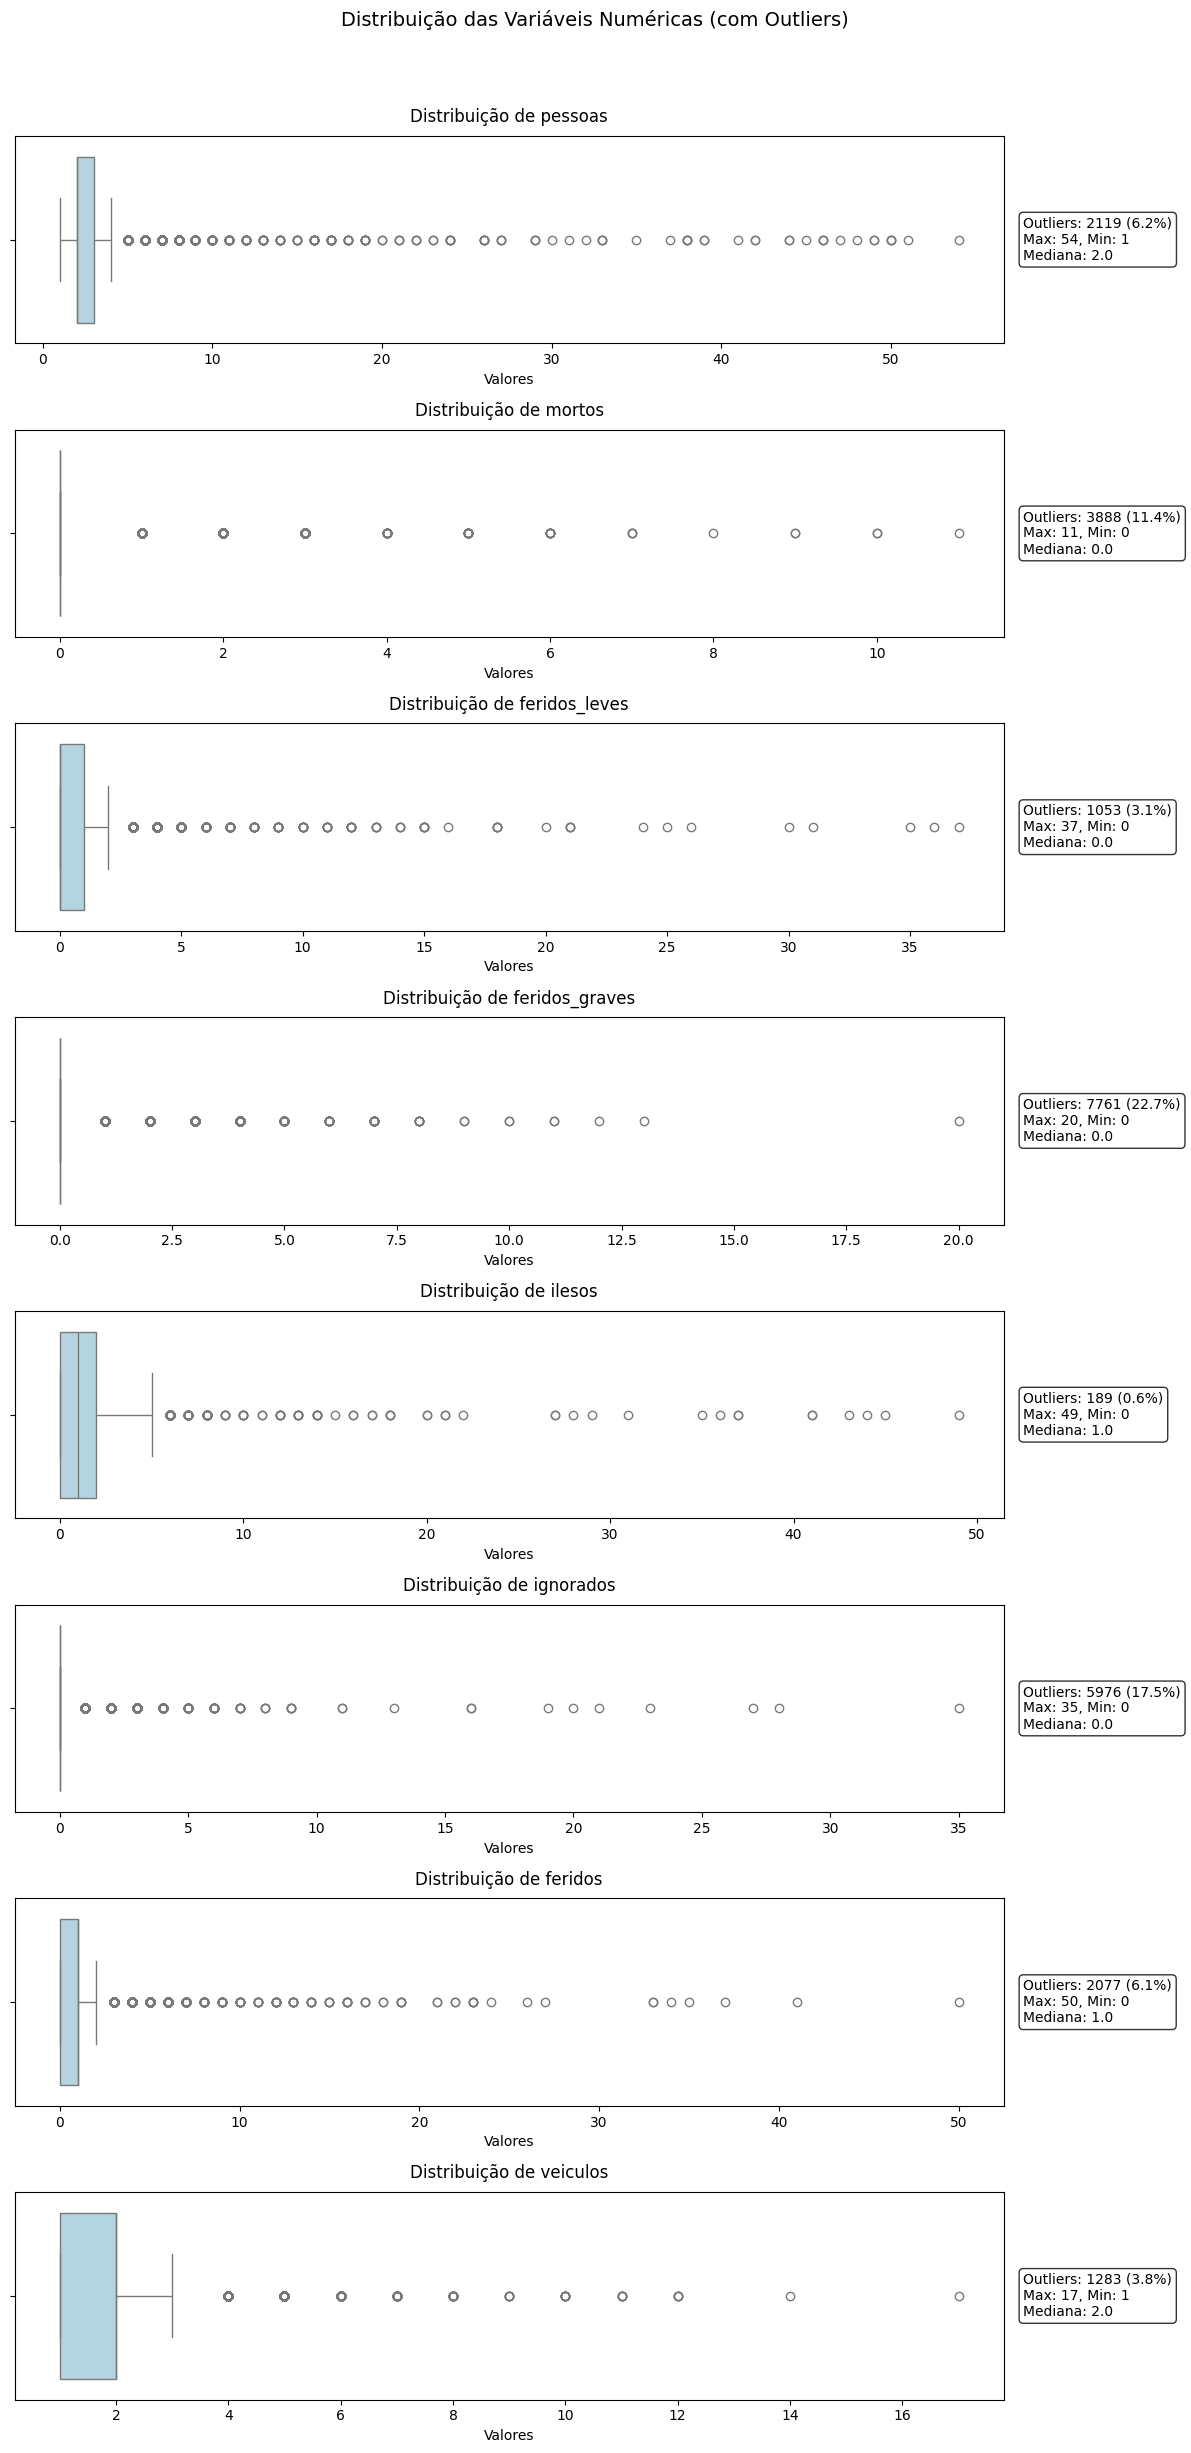

In [22]:
fig, axes = plt.subplots(len(colunas_numericas), 1, figsize=(12, 3*len(colunas_numericas)))
fig.suptitle('Distribuição das Variáveis Numéricas (com Outliers)', fontsize=14, y=1.02)

for i, coluna in enumerate(colunas_numericas):
    sns.boxplot(data=df, x=coluna, ax=axes[i], orient='horizontal', color='lightblue')
    
    axes[i].set_title(f'Distribuição de {coluna}', pad=10)
    axes[i].set_xlabel('Valores')
    
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[coluna] < (Q1 - 1.5 * IQR)) | (df[coluna] > (Q3 + 1.5 * IQR))][coluna]
    
    stats_text = f'Outliers: {len(outliers)} ({(len(outliers)/len(df)*100):.1f}%)\n'
    stats_text += f'Max: {df[coluna].max():.0f}, Min: {df[coluna].min():.0f}\n'
    stats_text += f'Mediana: {df[coluna].median():.1f}'
    
    axes[i].text(1.02, 0.5, stats_text,
                transform=axes[i].transAxes,
                verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Como acidentes de transito são eventos que naturalmente seguem uma distribuição assimétrica, em que acidentes graves com multiplas vitimas são raros, os eventos presentes nesse dataset representam casos reaias, que mesmo que se parecam com outliers eles são importantes para o modelo.

## Analise de distribuição dos dados

**Importante:** Executar esse passo depois de executar o pipeline

In [23]:
df = pd.read_csv('..\\..\\files\\processed\\datatran_ma_processado.csv')

In [24]:
df.head()

,dia_semana,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,sentido_via,condicao_metereologica,tipo_pista,...,feridos_leves,feridos_graves,ilesos,ignorados,veiculos,data,ano,periodo_dia,gravidade_acidente,causa_acidente_grupo
0,segunda-feira,316,516,CAXIAS,Ultrapassagem indevida,capotamento,sem vitimas,Crescente,Ceu Claro,Simples,...,0,0,2,0,2,2007-01-01,2007,manha,sem_vitimas,comportamento_risco
1,segunda-feira,222,556,BOM JESUS DAS SELVAS,Velocidade incompatível,saida de leito carrocavel,com vitimas fatais,Crescente,Nublado,Simples,...,1,0,0,0,1,2007-01-01,2007,madrugada,fatal,comportamento_risco
2,segunda-feira,230,23,BARAO DE GRAJAU,Animais na Pista,atropelamento de animal,com vitimas feridas,Decrescente,Ceu Claro,Simples,...,3,0,1,0,1,2007-01-01,2007,noite,leve,fatores_externos_animais
3,segunda-feira,10,216,GOVERNADOR EDISON LOBAO,Defeito na via,saida de leito carrocavel,sem vitimas,Decrescente,Chuva,Simples,...,0,0,1,0,1,2007-01-01,2007,tarde,sem_vitimas,problemas_tecnicos_via
4,segunda-feira,135,23,SAO LUIS,Falta de atenção,colisão lateral,sem vitimas,Crescente,Ceu Claro,Simples,...,0,0,2,0,2,2007-01-01,2007,manha,sem_vitimas,falha_atencao


### Analise temporal

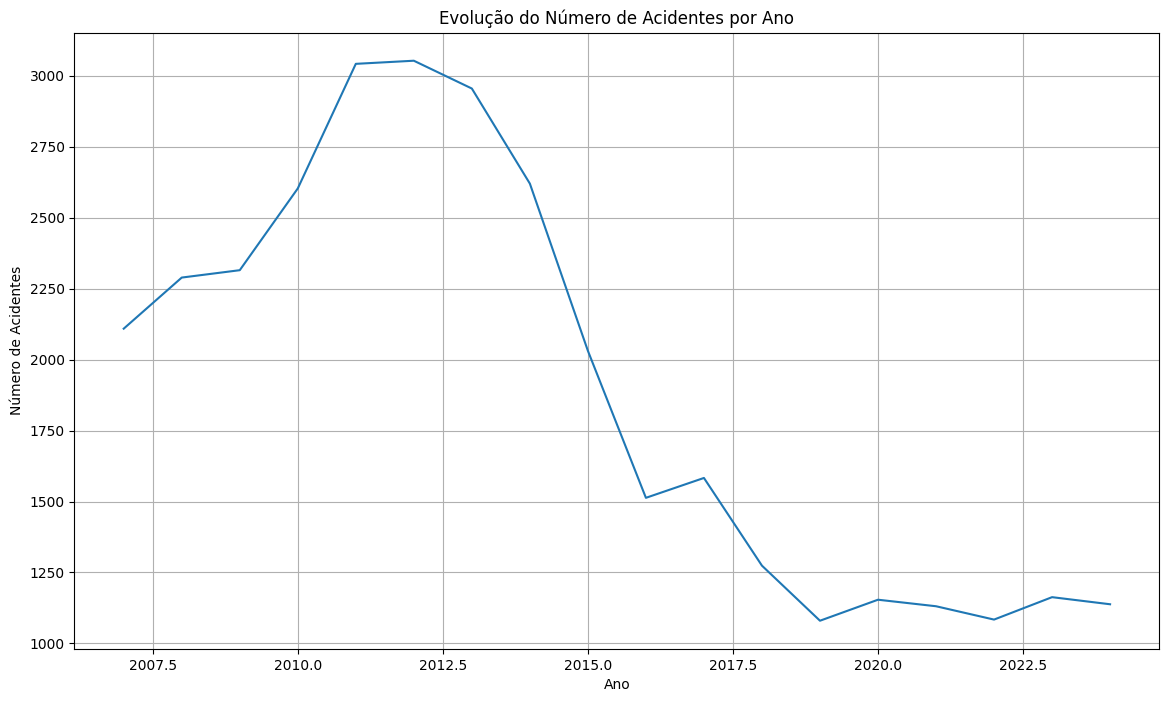

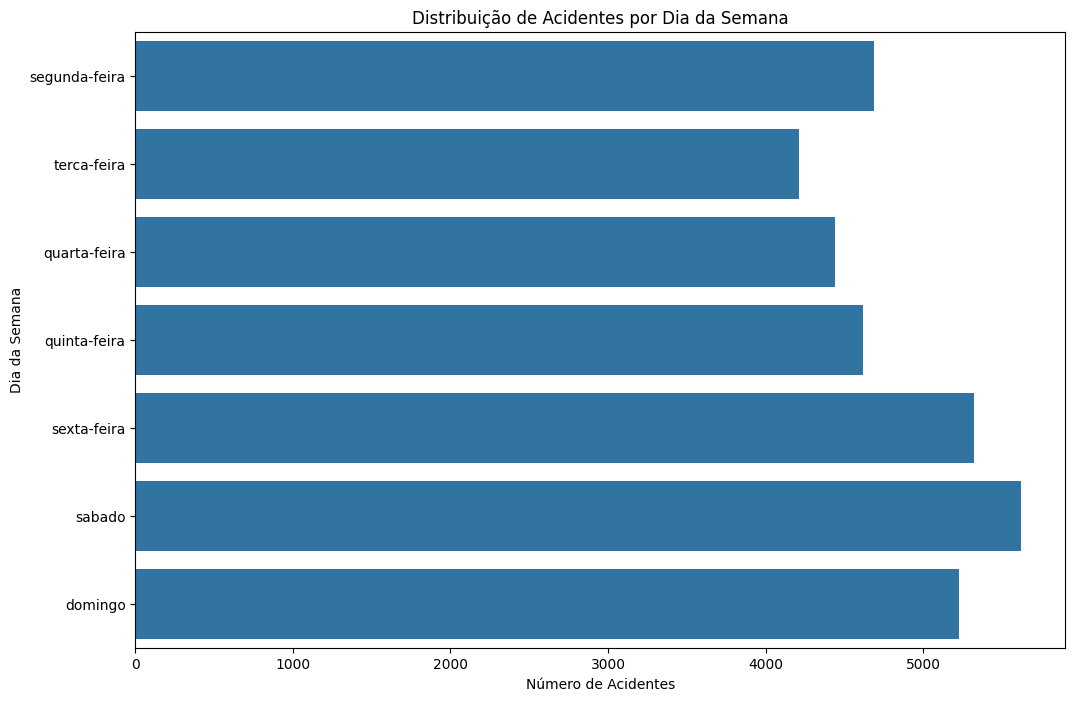

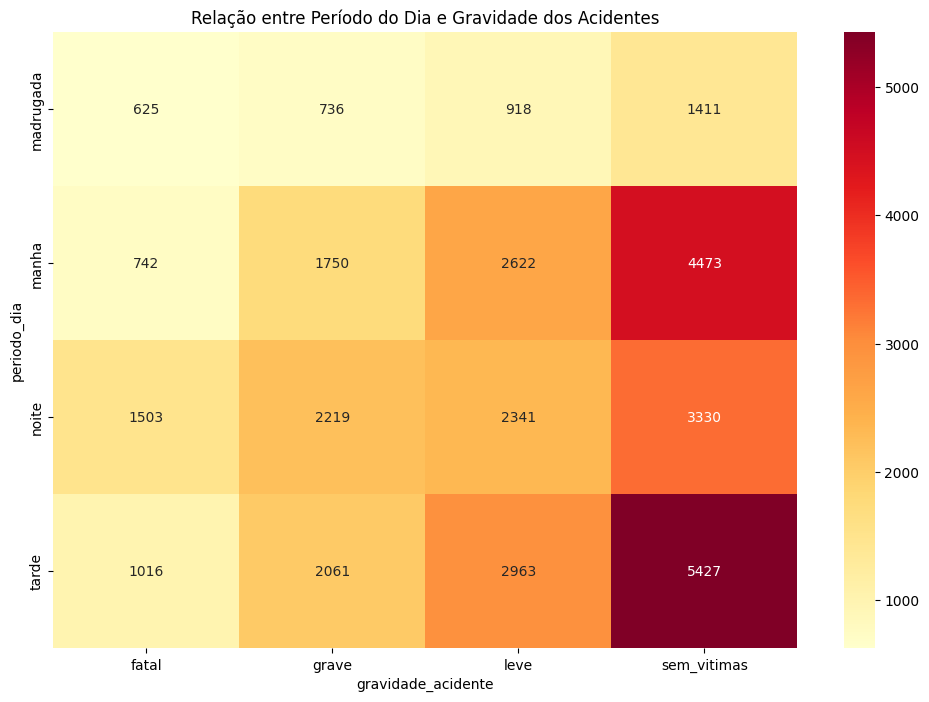

In [25]:
# Evolução anual
plt.figure(figsize=(14, 8))
acidentes_por_ano = df['ano'].value_counts().sort_index()
sns.lineplot(x=acidentes_por_ano.index, y=acidentes_por_ano.values)
plt.title('Evolução do Número de Acidentes por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Acidentes')
plt.grid(True)
plt.show()

# Distribuição por dia da semana
plt.figure(figsize=(12, 8))
ordem_dias = ['segunda-feira', 'terca-feira', 'quarta-feira', 'quinta-feira', 
             'sexta-feira', 'sabado', 'domingo']
sns.countplot(data=df, y='dia_semana', order=ordem_dias)
plt.title('Distribuição de Acidentes por Dia da Semana')
plt.xlabel('Número de Acidentes')
plt.ylabel('Dia da Semana')
plt.show()

# Heatmap período x gravidade
plt.figure(figsize=(12, 8))
periodo_gravidade = pd.crosstab(df['periodo_dia'], df['gravidade_acidente'])
sns.heatmap(periodo_gravidade, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Relação entre Período do Dia e Gravidade dos Acidentes')
plt.show()

### Análise Geográfica


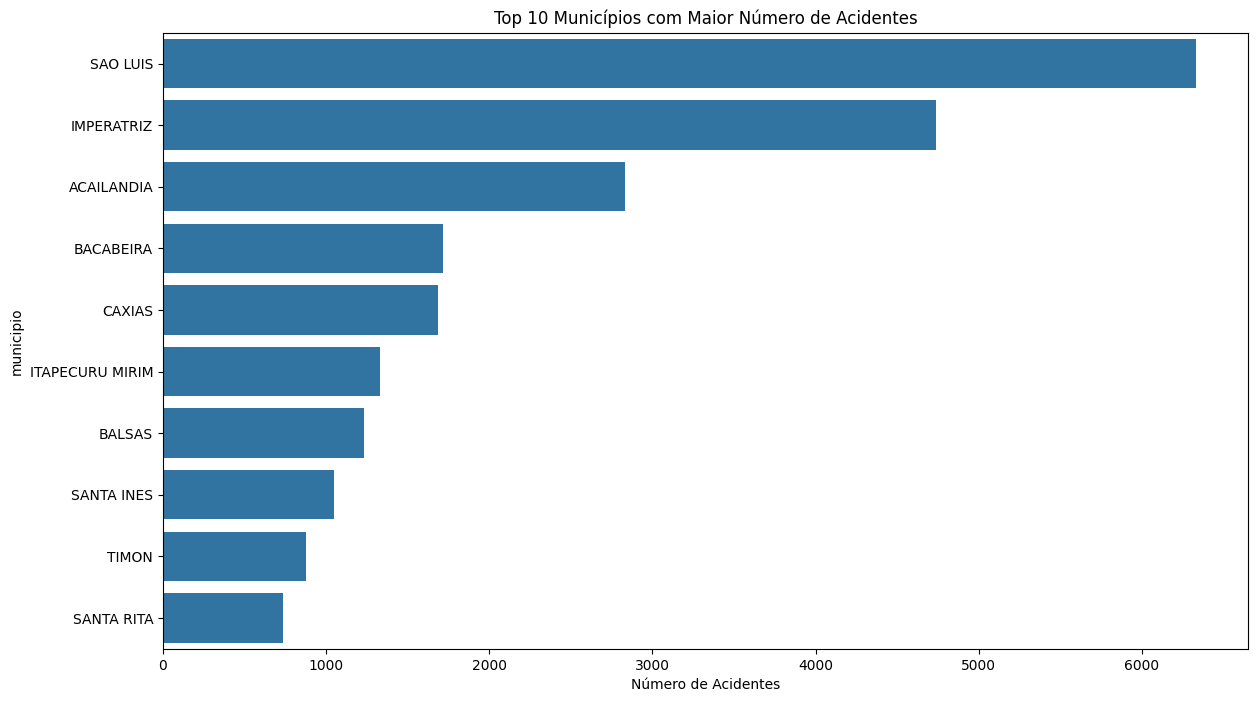

<Figure size 1200x800 with 0 Axes>

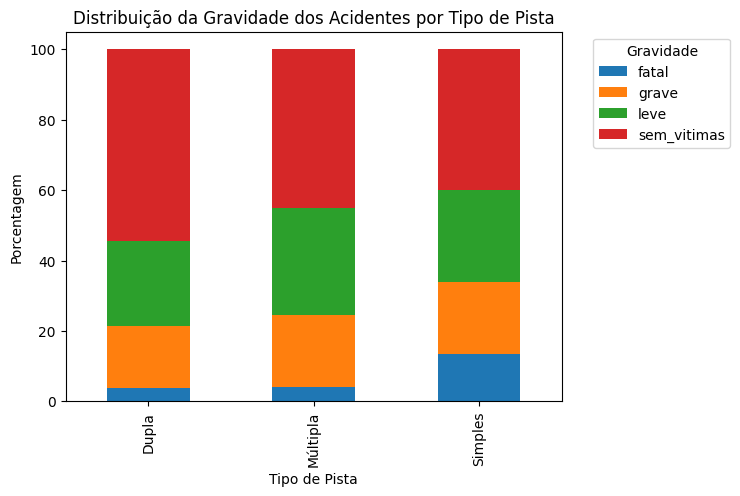

In [26]:
# Top 10 municípios
plt.figure(figsize=(14, 8))
top_municipios = df['municipio'].value_counts().head(10)
sns.barplot(x=top_municipios.values, y=top_municipios.index)
plt.title('Top 10 Municípios com Maior Número de Acidentes')
plt.xlabel('Número de Acidentes')
plt.show()

# Distribuição por tipo de pista
plt.figure(figsize=(12, 8))
gravidade_pista = pd.crosstab(df['tipo_pista'], df['gravidade_acidente'], 
                             normalize='index') * 100
gravidade_pista.plot(kind='bar', stacked=True)
plt.title('Distribuição da Gravidade dos Acidentes por Tipo de Pista')
plt.xlabel('Tipo de Pista')
plt.ylabel('Porcentagem')
plt.legend(title='Gravidade', bbox_to_anchor=(1.05, 1))
plt.show()

### Análise de Severidade

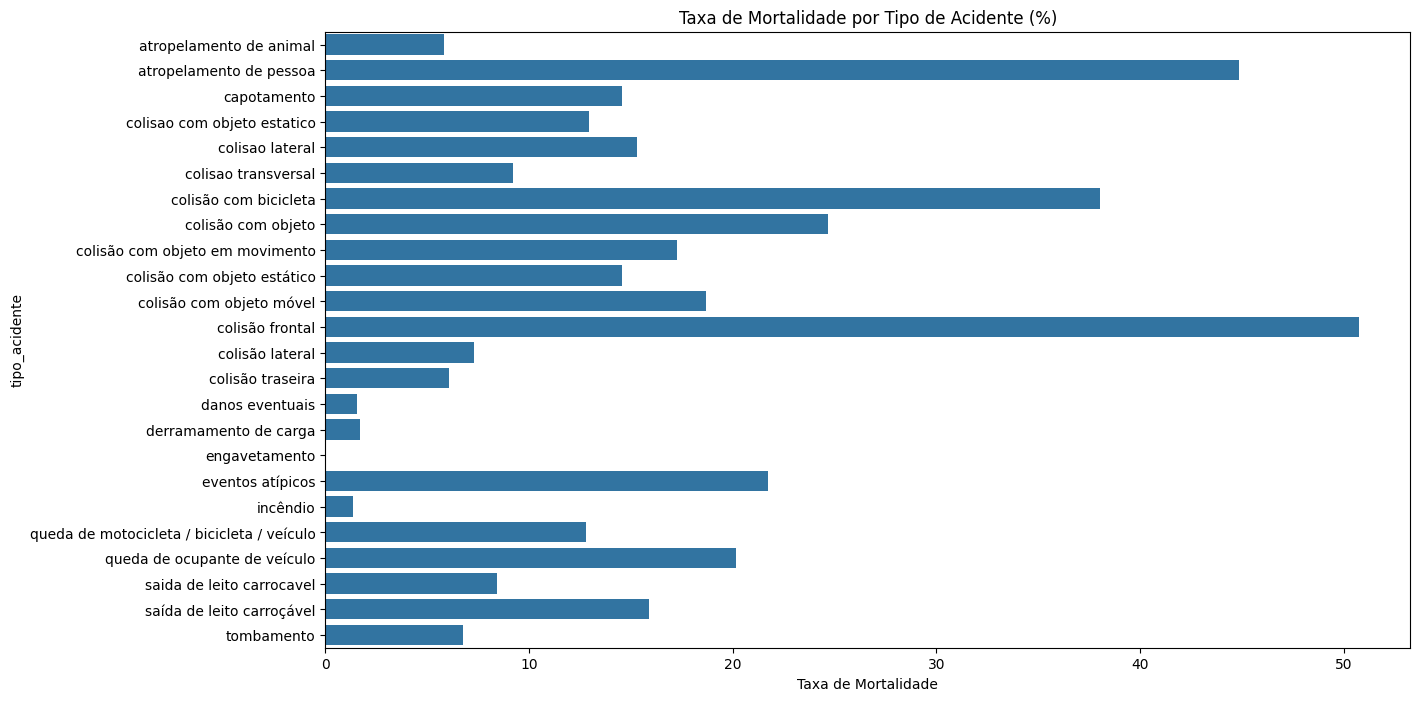

In [27]:
plt.figure(figsize=(14, 8))
mortalidade = df.groupby('tipo_acidente').agg({
    'mortos': 'sum',
    'tipo_acidente': 'count'
}).rename(columns={'tipo_acidente': 'total'})
mortalidade['taxa_mortalidade'] = (mortalidade['mortos'] / mortalidade['total']) * 100

sns.barplot(x=mortalidade['taxa_mortalidade'], y=mortalidade.index)
plt.title('Taxa de Mortalidade por Tipo de Acidente (%)')
plt.xlabel('Taxa de Mortalidade')
plt.show()


### Análise de Risco

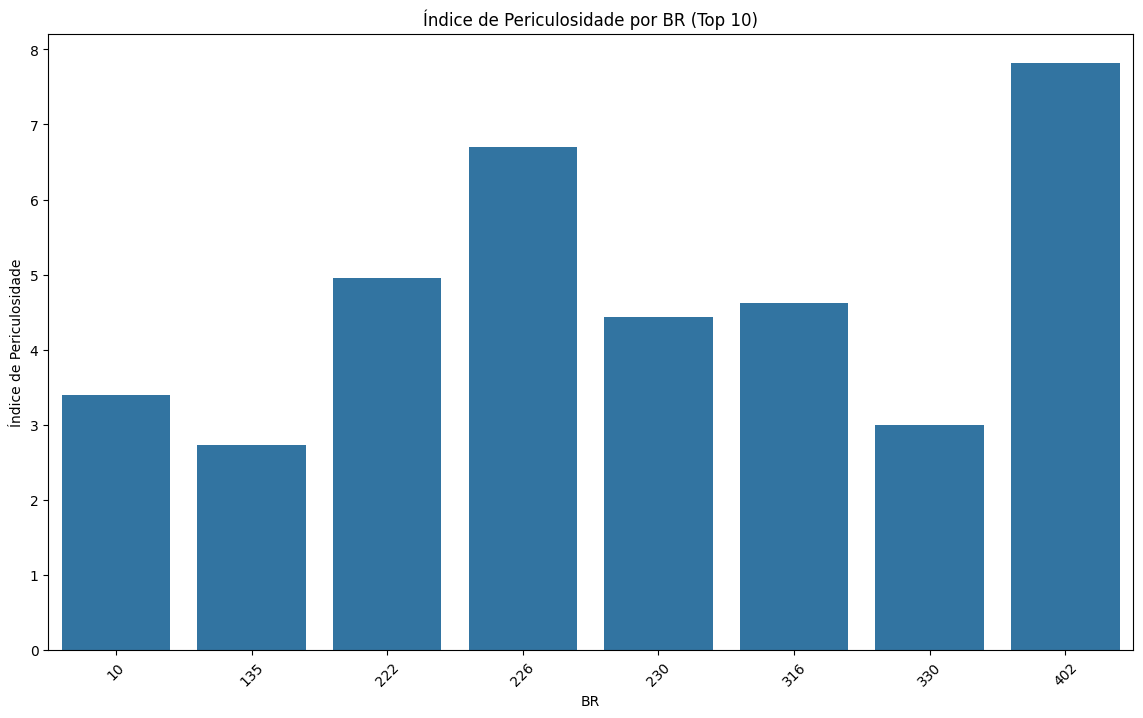

<Figure size 1200x800 with 0 Axes>

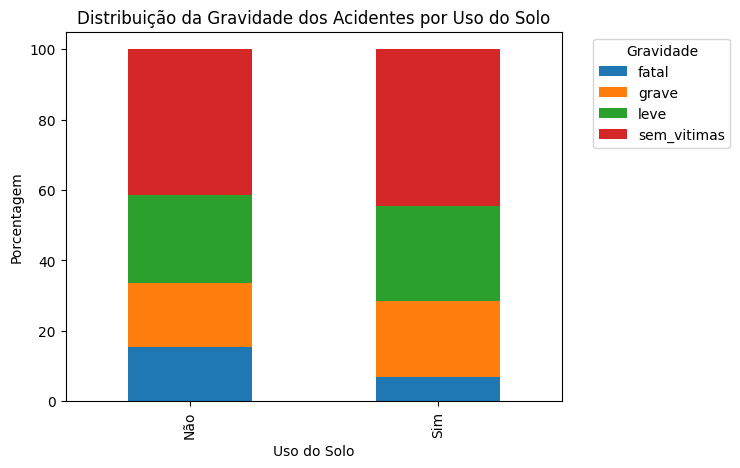

In [28]:
# Índice de periculosidade por BR
plt.figure(figsize=(14, 8))
br_mask = ~df['br'].isin([0, 1])
df_br_valida = df[br_mask]
risco_br = df_br_valida.groupby('br').agg({
    'mortos': 'sum',
    'feridos_graves': 'sum',
    'feridos_leves': 'sum',
    'br': 'count'
}).rename(columns={'br': 'total_acidentes'})

risco_br['indice_periculosidade'] = (
    (risco_br['mortos'] * 13) +
    (risco_br['feridos_graves'] * 5) +
    risco_br['feridos_leves']
) / risco_br['total_acidentes']

top_br_risco = risco_br.sort_values('indice_periculosidade', ascending=False).head(10)

sns.barplot(x=top_br_risco.index, y=top_br_risco['indice_periculosidade'])
plt.title('Índice de Periculosidade por BR (Top 10)')
plt.xlabel('BR')
plt.ylabel('Índice de Periculosidade')
plt.xticks(rotation=45)
plt.show()

# Relação uso do solo x gravidade
plt.figure(figsize=(12, 8))
uso_solo_grav = pd.crosstab(df['uso_solo'], df['gravidade_acidente'], normalize='index') * 100
uso_solo_grav.plot(kind='bar', stacked=True)
plt.title('Distribuição da Gravidade dos Acidentes por Uso do Solo')
plt.xlabel('Uso do Solo')
plt.ylabel('Porcentagem')
plt.legend(title='Gravidade', bbox_to_anchor=(1.05, 1))
plt.show()

### Analise Gravidade x Causa

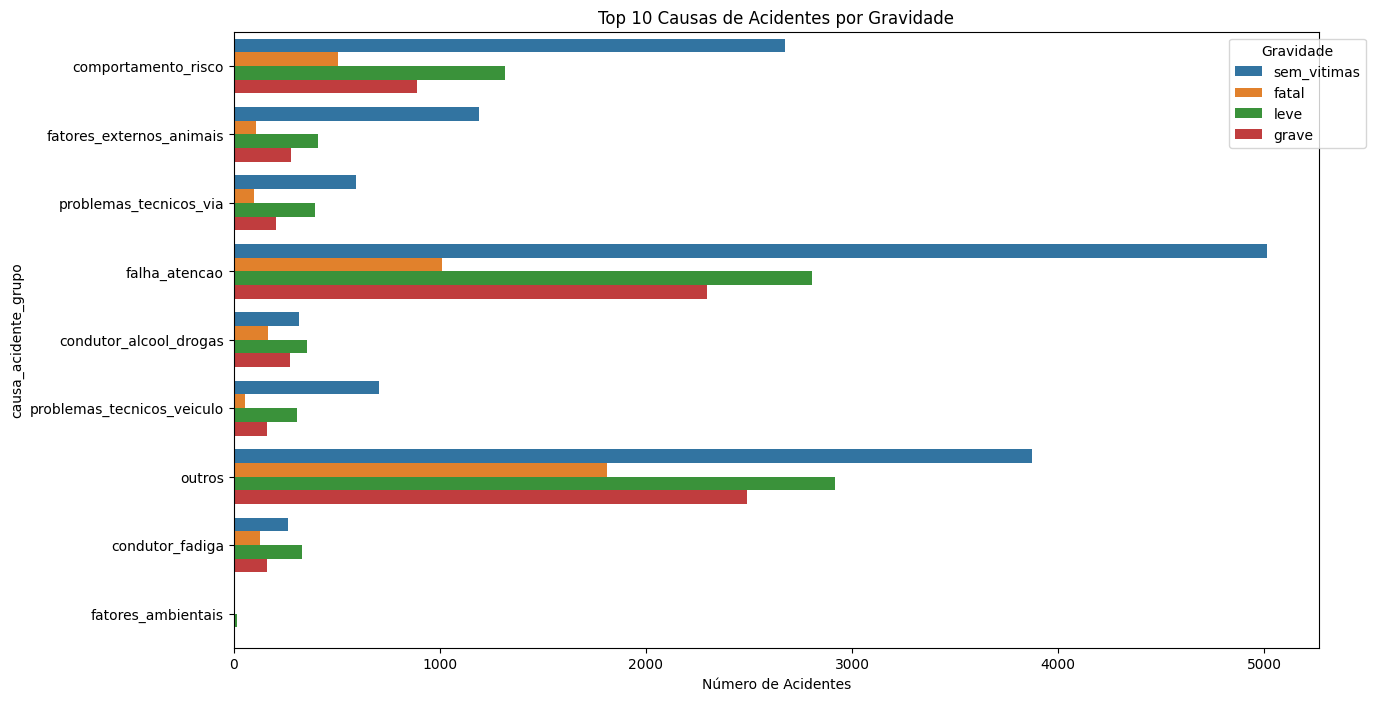

In [29]:
# Top causas por gravidade
plt.figure(figsize=(14, 8))
top_causas = df['causa_acidente_grupo'].value_counts().head(10).index
causa_grave = df[df['causa_acidente_grupo'].isin(top_causas)]
sns.countplot(data=causa_grave, y='causa_acidente_grupo', hue='gravidade_acidente')
plt.title('Top 10 Causas de Acidentes por Gravidade')
plt.xlabel('Número de Acidentes')
plt.legend(title='Gravidade', bbox_to_anchor=(1.05, 1))

Com essa analise exploratória inicial, entendemos como funciona a distriuição dos dados, além disso também conseguimos observar os campos que precisam de ajustes durante o pré-processamento.

O próximo passo, é desenvolver o modelo para classificação de gravidade de acidente, com os resultados no pipeline de pre-processamento desenvolvido.